# Tensorboard Tutorial

## Getting Started 

Attribution: [Neptune.ai](https://neptune.ai/blog/tensorboard-tutorial)

### Useful Resources

- https://www.tensorflow.org/tensorboard
- https://github.com/tensorflow/tensorboard
- https://tensorboard.dev/


## Key Concepts

### Summary Ops: How TensorBoard gets data from TensorFlow

The first step in using TensorBoard is acquiring data from your TensorFlow run.
For this, you need
[summary ops](https://www.tensorflow.org/api_docs/python/tf/summary).
Summary ops are ops, just like
[`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul)
and
[`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu),
which means they take in tensors, produce tensors, and are evaluated from within
a TensorFlow graph. However, summary ops have a twist: the Tensors they produce
contain serialized protobufs, which are written to disk and sent to TensorBoard.
To visualize the summary data in TensorBoard, you should evaluate the summary
op, retrieve the result, and then write that result to disk using a
summary.FileWriter. A full explanation, with examples, is in [the
tutorial](https://www.tensorflow.org/get_started/summaries_and_tensorboard).

The supported summary ops include:
* [`tf.summary.scalar`](https://www.tensorflow.org/api_docs/python/tf/summary/scalar)
* [`tf.summary.image`](https://www.tensorflow.org/api_docs/python/tf/summary/image)
* [`tf.summary.audio`](https://www.tensorflow.org/api_docs/python/tf/summary/audio)
* [`tf.summary.text`](https://www.tensorflow.org/api_docs/python/tf/summary/text)
* [`tf.summary.histogram`](https://www.tensorflow.org/api_docs/python/tf/summary/histogram)

### Tags: Giving names to data

When you make a summary op, you will also give it a `tag`. The tag is basically
a name for the data recorded by that op, and will be used to organize the data
in the frontend. The scalar and histogram dashboards organize data by tag, and
group the tags into folders according to a directory/like/hierarchy. If you have
a lot of tags, we recommend grouping them with slashes.

### Event Files & LogDirs: How TensorBoard loads the data

`summary.FileWriters` take summary data from TensorFlow, and then write them to a
specified directory, known as the `logdir`. Specifically, the data is written to
an append-only record dump that will have "tfevents" in the filename.
TensorBoard reads data from a full directory, and organizes it into the history
of a single TensorFlow execution.

Why does it read the whole directory, rather than an individual file? You might
have been using
[supervisor.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/training/supervisor.py)
to run your model, in which case if TensorFlow crashes, the supervisor will
restart it from a checkpoint. When it restarts, it will start writing to a new
events file, and TensorBoard will stitch the various event files together to
produce a consistent history of what happened.

### Runs: Comparing different executions of your model

You may want to visually compare multiple executions of your model; for example,
suppose you've changed the hyperparameters and want to see if it's converging
faster. TensorBoard enables this through different "runs". When TensorBoard is
passed a `logdir` at startup, it recursively walks the directory tree rooted at
`logdir` looking for subdirectories that contain tfevents data. Every time it
encounters such a subdirectory, it loads it as a new `run`, and the frontend
will organize the data accordingly.

For example, here is a well-organized TensorBoard log directory, with two runs,
"run1" and "run2".

```
/some/path/mnist_experiments/
/some/path/mnist_experiments/run1/
/some/path/mnist_experiments/run1/events.out.tfevents.1456525581.name
/some/path/mnist_experiments/run1/events.out.tfevents.1456525585.name
/some/path/mnist_experiments/run2/
/some/path/mnist_experiments/run2/events.out.tfevents.1456525385.name
/tensorboard --logdir /some/path/mnist_experiments
```

#### Logdir & Logdir_spec (Legacy Mode)

You may also pass a comma separated list of log directories, and TensorBoard
will watch each directory. You can also assign names to individual log
directories by putting a colon between the name and the path, as in

```
tensorboard --logdir_spec name1:/path/to/logs/1,name2:/path/to/logs/2
```

_This flag (`--logdir_spec`) is discouraged and can usually be avoided_. TensorBoard walks log directories recursively; for finer-grained control, prefer using a symlink tree. _Some features may not work when using `--logdir_spec` instead of `--logdir`._

Install these libraries - I'm using a `virtualenv` with Python 3.7

In [44]:
!pip install tensorflow
!pip install matplotlib
!pip install tensorboard
!pip install sklearn

With TensorBoard installed, you can now load it into your Notebook. Note that you can use it in a Jupyter Notebook or Google’s Colab. 

In [38]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Once that is done you have to set a log directory. This is where TensorBoard will store all the logs. It will read from these logs in order to display the various visualizations.

In [2]:
log_folder = 'logs'

In [3]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### How to run TensorBoard
Running Tensorboard involves just one line of code. In this section you’ll see how to do this. 

Let’s now walk through an example where you will use TensorBoard to visualize model metrics. For that purpose, you need to build a simple image classification model.

In [6]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

model = tf.keras.models.Sequential([
   tf.keras.layers.Flatten(input_shape=(28, 28)),
   tf.keras.layers.Dense(512, activation='relu'),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='sgd', 
   loss='sparse_categorical_crossentropy',
   metrics=['accuracy'])

11493376/11490434 [==============================] - 1s 0us/step


Next, load in the TensorBoard notebook extension and create a variable pointing to the log folder. 



In [7]:
%load_ext tensorboard
log_folder = 'logs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Tensorflow Callback

The next step is to specify the TensorBoard callback during the model’s fit method. In order to do that you first have to import the TensorBoard callback.

This callback is responsible for logging events such as Activation Histograms, Metrics Summary Plots, Profiling and Training Graph Visualizations. 

In [15]:
from tensorflow.keras.callbacks import TensorBoard

In [9]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

With that in place, you can now create the TensorBoard callback and specify the log directory using log_dir. The TensorBoard callback also takes other parameters:

- `histogram_freq` is the frequency at which to compute activation and weight histograms for layers of the model. Setting this to 0 means that histograms will not be computed. In order for this to work you have to set the validation data or the validation split. 
- `write_graph` dictates if the graph will be visualized in TensorBoard 
- `write_images` when set to true, model weights are visualized as an image in TensorBoard
- `update_freq` determines how losses and metrics are written to TensorBoard. When set to an integer, say 100, losses and metrics are logged every 100 batches. When set to batch the losses and metrics are set after every batch. When set to epoch they are written after every epoch
- `profile_batch` determines which batches will be profiled. By default, the second batch is profiled. You can also set, for example from 5 and to 10, to profile batches 5 to 10, i.e profile_batch=’5,10′ . Setting profile_batch to 0 disables profiling.
- `embeddings_freq` the frequency at which the embedding layers will be visualized. Setting this to zero means that the embeddings will not be visualized

The next item is to fit the model and pass in the callback.

In [10]:
model.fit(X_train, y_train,
          epochs=10,
          validation_split=0.2,
          callbacks=callbacks)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 1.1236 - accuracy: 0.7029 - val_loss: 0.3686 - val_accuracy: 0.9004
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3912 - accuracy: 0.8911 - val_loss: 0.3010 - val_accuracy: 0.9176
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3302 - accuracy: 0.9071 - val_loss: 0.2656 - val_accuracy: 0.9262
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2859 - accuracy: 0.9198 - val_loss: 0.2404 - val_accuracy: 0.9330
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2538 - accuracy: 0.9276 - val_loss: 0.2225 - val_accuracy: 0.9382
Epoch 6/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2404 - accuracy: 0.9318 - val_loss: 0.2069 - val_accuracy: 0.9418
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2221 - accuracy: 0.9371 - val_loss: 0.1940 - val_accuracy:

Open Tensorboard by visitng http://localhost:6006

In [14]:
%tensorboard --logdir={'/Users/dileepholla/PycharmProjects/tensorboard/logs'}

#### TensorBoard scalars
The Scalars tab shows changes in the loss and metrics over the epochs. It can be used to track other scalar values such as learning rate and training speed.

#### TensorBoard images
This dashboard has images that show the weights. Adjusting the slider displays the weights at various epochs. 

#### TensorBoard graphs
This tab shows your model’s layers. You can use this to check if the architecture of the model looks as intended. 

#### TensorBoard distributions
The distribution tab shows the distribution of tensors. For example in the dense layer below, you can see the distribution of the weights and biases over each epoch.

#### TensorBoard histograms
The Histograms show the distribution of tensors over time. For example, looking at dense_1 below, you can see the distribution of the biases over each epoch. 

### Plot training examples with TensorBoard

You can use TensorFlow Image Summary API to visualize training images. This is especially useful when working with image data like in this case.

Now, create a new log directory for the images as shown below & create a file writer pointing to the directory

In [18]:
logdir = "logs/train_data/"
file_writer = tf.summary.create_file_writer(logdir)

At the beginning of this article (in the “How to run TensorBoard” section), you specified that the image shape was 28 by 28. It is important information when reshaping the images before writing them to TensorBoard. You also need to specify the channel to be 1 because the images are grayscale. Afterward, you use the file_write to write the images to TensorBoard. 

In this example, the images at index 10 to 30 will be written to TensorBoard. 

In [19]:
import numpy as np

with file_writer.as_default():
    images = np.reshape(X_train[10:30], (-1, 28, 28, 1))
    tf.summary.image("20 Digits", images, max_outputs=25, step=0)

Apart from visualizing image tensors, you can also visualize actual images in TensorBoard. In order to illustrate that,  you need to convert the MNIST tensors to images using Matplotlib. After that, you need to use `tf.summary.image` to plot the images in Tensorboard. 

Start by clearing the logs, alternatively you can use timestamped log folders. After that specify the log directory and create a `tf.summary.create_file_writer` that will be used to write the images to TensorBoard

In [20]:
!rm -rf logs

In [24]:
import io
import matplotlib.pyplot as plt

class_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']
logdir = "logs/plots/"
file_writer = tf.summary.create_file_writer(logdir)

Next, create a grid that will hold the images. In this case, the grid will hold 36 digits.



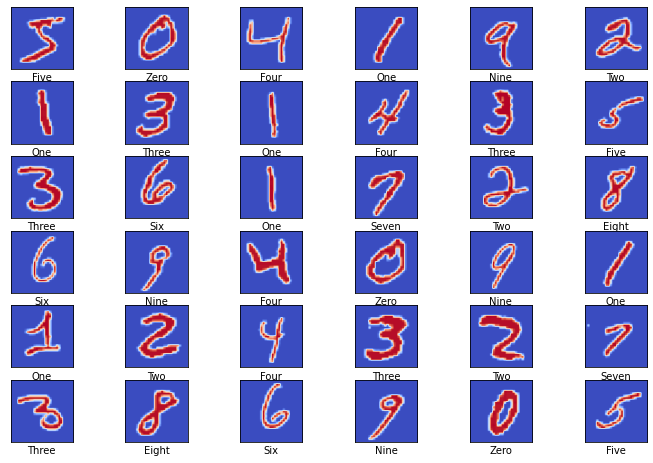

In [25]:
def image_grid():  
    figure = plt.figure(figsize=(12,8))

    for i in range(36):    
        plt.subplot(6, 6, i + 1)
        plt.xlabel(class_names[y_train[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train[i], cmap=plt.cm.coolwarm)

    return figure

figure = image_grid()

Now convert the digits into a single image to visualize it in the TensorBoard.



In [26]:
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

The next step is to use the writer and `plot_to_image` to display the images on TensorBoard.



In [27]:
with file_writer.as_default():    
    tf.summary.image("MNIST Digits", plot_to_image(figure), step=0)

<Figure size 432x288 with 0 Axes>

In [30]:
%tensorboard --logdir logs/plots

Reusing TensorBoard on port 6007 (pid 86671), started 0:01:43 ago. (Use '!kill 86671' to kill it.)

## Log confusion matrix to TensorBoard
Using the same example, you can log the confusion matrix for all epochs. First, define a function that will return a Matplotlib figure holding the confusion matrix. 

In [31]:
import itertools 

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

Next, clear the previous logs, define the log directory for the confusion matrix, and create a writer variable for writing into the log folder. 

In [33]:
!rm -rf logs

logdir = "logs"
file_writer_cm = tf.summary.create_file_writer(logdir)

The step that follows this is to create a function that will make predictions from the model and log the confusion matrix as an image. 

After that use the `file_writer_cm to write` the confusion matrix to the log directory. 

In [39]:
from tensorflow import keras
from sklearn import metrics

def log_confusion_matrix(epoch, logs):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    cm = metrics.confusion_matrix(y_test, predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

This will be followed by the definition of the TensorBoard callback and the `LambdaCallback`. 

The `LambdaCallback` will log the confusion matrix on every epoch. Finally fit the model using these two callbacks. 

Since you’ve already fitted the model before, it would be advisable to restart your runtime and ensure that you are fitting the model just once.

In [40]:
callbacks = [
   TensorBoard(log_dir=log_folder, 
               histogram_freq=1, 
               write_graph=True,
               write_images=True,
               update_freq='epoch',
               profile_batch=2,
               embeddings_freq=1),
   keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
]

model.fit(X_train, y_train,
          epochs=10,
          validation_split=0.2,
          callbacks=callbacks)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1696 - accuracy: 0.9515 - val_loss: 0.1589 - val_accuracy: 0.9565
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1621 - accuracy: 0.9542 - val_loss: 0.1515 - val_accuracy: 0.9587
Epoch 3/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1543 - accuracy: 0.9565 - val_loss: 0.1468 - val_accuracy: 0.9592
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1463 - accuracy: 0.9584 - val_loss: 0.1405 - val_accuracy: 0.9614
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1395 - accuracy: 0.9612 - val_loss: 0.1355 - val_accuracy: 0.9625
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1347 - accuracy: 0.9626 - val_loss: 0.1319 - val_accuracy: 0.9628
Epoch 7/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1295 - accuracy: 0.9636 - val_loss: 0.1283 - val_accuracy:

Now run TensorBoard and check the confusion matrix on the Images tab. 



In [42]:
%tensorboard --logdir logs